#### IMPORT

In [1]:
import os, platform

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 37 #644 #322 #644 #37 #644 #37 #98 #190 #61 #37 #46
# N_CLASSES=3
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
DATASET_DIR_NAME = "dataset\set01\\01_original"
SAMPLE_DATASET_NAME = "train" + ".csv"
ACTUAL_DATASET_NAME = "test" + ".csv"

MODEL_DIR_NAME = "dataset\set01\\01_original"
MODEL_NAME = "model_" + "set01_01_original" + ".h5"

RESULT_DIR_NAME = "dataset\set01\\01_original"
RESULT_NAME = "result_" + "set01_01_original" + ".csv"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
print(DATASET_DIR_PATH)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME)

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME)

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME)

CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 3
        
CLASS_LIST = ['andy', 'azfar', 'ch', 'cy', 'gerald', 'jc', 'jonah', 'qikai', 'ys', 'zen']

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\01_original


In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\01_original
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set01\01_original


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print(n_classes)
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)


    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    # retrieve number of classes
    n_classes = y_train.shape[1]

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Number of Classes: {n_classes}")

    return X_train, X_test, y_train, y_test, n_classes

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X


#### LOAD DATASET

In [7]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Class,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T2-RF|6+7,T2-D|7,T2-I|7+8,T2-PF|7+8,T2-RF|7+8,T2-D|8,T2-I|8+9,T2-PF|8+9,T2-RF|8+9,T2-D|9
0,andy,3,mad wabble,0.155289,0.234703,0.091736,0.079413,0.142967,0.238084,0.072560,...,0.165704,0.119107,0.171939,0.040368,0.052832,0.131571,0.188983,0.075754,0.057412,0.113230
1,andy,3,bad reread,0.116150,0.285436,0.085726,0.169286,0.199709,0.248351,0.127091,...,0.076081,0.160108,0.271197,0.069895,0.111089,0.201302,0.291623,0.135957,0.090321,0.155666
2,andy,3,ink sienna,0.118185,0.273710,0.114184,0.155524,0.159526,0.248386,0.106931,...,0.196050,0.086095,0.257720,0.139502,0.171624,0.118217,0.253027,0.124216,0.134809,0.128811
3,andy,3,ion doxies,0.082255,0.330661,0.189420,0.248406,0.141242,0.283131,0.142228,...,0.124682,0.141366,0.203498,0.086235,0.062132,0.117263,0.199387,0.054129,0.082124,0.145257
4,andy,3,hey plains,0.106697,0.214285,0.117489,0.107588,0.096796,0.225085,0.090808,...,0.109095,0.125539,0.198049,0.046005,0.072510,0.152043,0.221190,0.082523,0.069147,0.138667


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


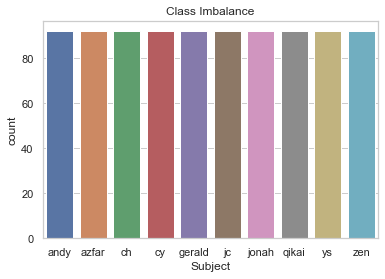

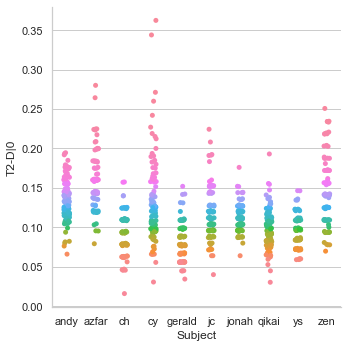

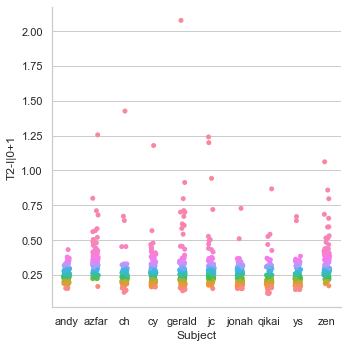

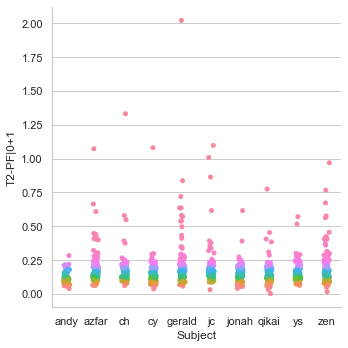

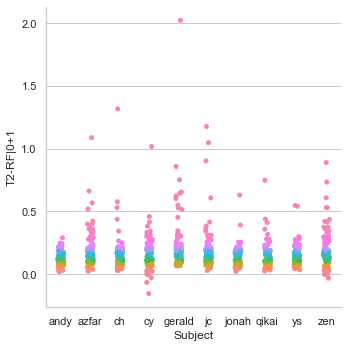

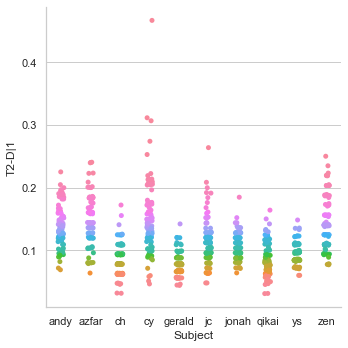

In [8]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [9]:
X, Y, lb = prepare_dataset(df)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (920, 37)
Y | Classes  | Dataset Shape: (920, 10)


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [10]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test, n_classes = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (736, 1, 37)
Y train shape: (736, 10)
X test shape: (184, 1, 37)
Y test shape: (184, 10)
Number of Classes: 10


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [11]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [12]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [13]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

10
Epoch 1/200
6/6 [==============================] - 6s 16ms/step - loss: 2.5899 - accuracy: 0.1241
Epoch 2/200
6/6 [==============================] - 0s 14ms/step - loss: 2.5524 - accuracy: 0.1241
Epoch 3/200
6/6 [==============================] - 0s 13ms/step - loss: 2.4973 - accuracy: 0.1105
Epoch 4/200
6/6 [==============================] - 0s 14ms/step - loss: 2.4887 - accuracy: 0.0969
Epoch 5/200
6/6 [==============================] - 0s 14ms/step - loss: 2.4234 - accuracy: 0.1105
Epoch 6/200
6/6 [==============================] - 0s 15ms/step - loss: 2.4025 - accuracy: 0.1122
Epoch 7/200
6/6 [==============================] - 0s 15ms/step - loss: 2.4015 - accuracy: 0.1105
Epoch 8/200
6/6 [==============================] - 0s 14ms/step - loss: 2.3644 - accuracy: 0.1207
Epoch 9/200
6/6 [==============================] - 0s 14ms/step - loss: 2.3670 - accuracy: 0.1088
Epoch 10/200
6/6 [==============================] - 0s 15ms/step - loss: 2.3804 - accuracy: 0.0833
Epoch 11/200
6/6

6/6 [==============================] - 0s 15ms/step - loss: 1.6573 - accuracy: 0.3401
Epoch 84/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6791 - accuracy: 0.3316
Epoch 85/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6517 - accuracy: 0.3588
Epoch 86/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6692 - accuracy: 0.3554
Epoch 87/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6299 - accuracy: 0.3622
Epoch 88/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6470 - accuracy: 0.3418
Epoch 89/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6412 - accuracy: 0.3401
Epoch 90/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6418 - accuracy: 0.3333
Epoch 91/200
6/6 [==============================] - 0s 14ms/step - loss: 1.6230 - accuracy: 0.3571
Epoch 92/200
6/6 [==============================] - 0s 15ms/step - loss: 1.6294 - accuracy: 0.3452
Epoch 93/200
6/6 [=====

6/6 [==============================] - 0s 15ms/step - loss: 1.2881 - accuracy: 0.5034
Epoch 166/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2764 - accuracy: 0.5255
Epoch 167/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2519 - accuracy: 0.5136
Epoch 168/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2235 - accuracy: 0.5391
Epoch 169/200
6/6 [==============================] - 0s 14ms/step - loss: 1.3298 - accuracy: 0.4830
Epoch 170/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2277 - accuracy: 0.5459
Epoch 171/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2318 - accuracy: 0.5459
Epoch 172/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2518 - accuracy: 0.5187
Epoch 173/200
6/6 [==============================] - 0s 14ms/step - loss: 1.2590 - accuracy: 0.5289
Epoch 174/200
6/6 [==============================] - 0s 15ms/step - loss: 1.2454 - accuracy: 0.5578
Epoch 175/200


6/6 [==============================] - 0s 17ms/step - loss: 1.9087 - accuracy: 0.2360
Epoch 47/200
6/6 [==============================] - 0s 17ms/step - loss: 1.8753 - accuracy: 0.2598
Epoch 48/200
6/6 [==============================] - 0s 16ms/step - loss: 1.8842 - accuracy: 0.2479
Epoch 49/200
6/6 [==============================] - 0s 16ms/step - loss: 1.8493 - accuracy: 0.2632
Epoch 50/200
6/6 [==============================] - 0s 17ms/step - loss: 1.8517 - accuracy: 0.2496
Epoch 51/200
6/6 [==============================] - 0s 16ms/step - loss: 1.8100 - accuracy: 0.2649
Epoch 52/200
6/6 [==============================] - 0s 16ms/step - loss: 1.8189 - accuracy: 0.2598
Epoch 53/200
6/6 [==============================] - 0s 16ms/step - loss: 1.8106 - accuracy: 0.2598
Epoch 54/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8156 - accuracy: 0.2598
Epoch 55/200
6/6 [==============================] - 0s 15ms/step - loss: 1.8012 - accuracy: 0.2632
Epoch 56/200
6/6 [=====

6/6 [==============================] - 0s 15ms/step - loss: 1.5221 - accuracy: 0.3735
Epoch 129/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4943 - accuracy: 0.3905
Epoch 130/200
6/6 [==============================] - 0s 15ms/step - loss: 1.5025 - accuracy: 0.3752
Epoch 131/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4614 - accuracy: 0.4109
Epoch 132/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4785 - accuracy: 0.3735
Epoch 133/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4910 - accuracy: 0.3905
Epoch 134/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4812 - accuracy: 0.3718
Epoch 135/200
6/6 [==============================] - 0s 14ms/step - loss: 1.5077 - accuracy: 0.4058
Epoch 136/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4902 - accuracy: 0.3939
Epoch 137/200
6/6 [==============================] - 0s 15ms/step - loss: 1.4522 - accuracy: 0.3888
Epoch 138/200


6/6 [==============================] - 0s 24ms/step - loss: 2.3444 - accuracy: 0.0917
Epoch 10/200
6/6 [==============================] - 0s 21ms/step - loss: 2.3380 - accuracy: 0.1087
Epoch 11/200
6/6 [==============================] - 0s 23ms/step - loss: 2.3523 - accuracy: 0.0951
Epoch 12/200
6/6 [==============================] - 0s 20ms/step - loss: 2.3344 - accuracy: 0.1002
Epoch 13/200
6/6 [==============================] - 0s 20ms/step - loss: 2.3500 - accuracy: 0.0985
Epoch 14/200
6/6 [==============================] - 0s 20ms/step - loss: 2.3249 - accuracy: 0.1121
Epoch 15/200
6/6 [==============================] - 0s 19ms/step - loss: 2.3280 - accuracy: 0.0900
Epoch 16/200
6/6 [==============================] - 0s 19ms/step - loss: 2.3476 - accuracy: 0.0798
Epoch 17/200
6/6 [==============================] - 0s 19ms/step - loss: 2.3356 - accuracy: 0.0815
Epoch 18/200
6/6 [==============================] - 0s 21ms/step - loss: 2.3344 - accuracy: 0.0968
Epoch 19/200
6/6 [=====

6/6 [==============================] - 0s 21ms/step - loss: 1.8455 - accuracy: 0.2971
Epoch 92/200
6/6 [==============================] - 0s 19ms/step - loss: 1.8448 - accuracy: 0.3022
Epoch 93/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8363 - accuracy: 0.2988
Epoch 94/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8434 - accuracy: 0.2886
Epoch 95/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8409 - accuracy: 0.3022
Epoch 96/200
6/6 [==============================] - 0s 21ms/step - loss: 1.8331 - accuracy: 0.3124
Epoch 97/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8308 - accuracy: 0.2903
Epoch 98/200
6/6 [==============================] - 0s 19ms/step - loss: 1.8299 - accuracy: 0.3005
Epoch 99/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8384 - accuracy: 0.2835
Epoch 100/200
6/6 [==============================] - 0s 22ms/step - loss: 1.8342 - accuracy: 0.3039
Epoch 101/200
6/6 [===

6/6 [==============================] - 0s 19ms/step - loss: 1.4247 - accuracy: 0.4295
Epoch 174/200
6/6 [==============================] - 0s 20ms/step - loss: 1.3958 - accuracy: 0.4516
Epoch 175/200
6/6 [==============================] - 0s 18ms/step - loss: 1.3713 - accuracy: 0.4703
Epoch 176/200
6/6 [==============================] - 0s 19ms/step - loss: 1.4113 - accuracy: 0.4771
Epoch 177/200
6/6 [==============================] - 0s 25ms/step - loss: 1.3534 - accuracy: 0.4805
Epoch 178/200
6/6 [==============================] - 0s 21ms/step - loss: 1.3848 - accuracy: 0.4771
Epoch 179/200
6/6 [==============================] - 0s 22ms/step - loss: 1.3795 - accuracy: 0.4635
Epoch 180/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3576 - accuracy: 0.4703
Epoch 181/200
6/6 [==============================] - 0s 20ms/step - loss: 1.3528 - accuracy: 0.5008
Epoch 182/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3549 - accuracy: 0.4737
Epoch 183/200


6/6 [==============================] - 0s 19ms/step - loss: 1.9612 - accuracy: 0.1986
Epoch 55/200
6/6 [==============================] - 0s 21ms/step - loss: 1.9614 - accuracy: 0.1902
Epoch 56/200
6/6 [==============================] - 0s 19ms/step - loss: 1.9134 - accuracy: 0.2326
Epoch 57/200
6/6 [==============================] - 0s 20ms/step - loss: 1.9210 - accuracy: 0.2173
Epoch 58/200
6/6 [==============================] - 0s 19ms/step - loss: 1.9181 - accuracy: 0.2241
Epoch 59/200
6/6 [==============================] - 0s 24ms/step - loss: 1.8718 - accuracy: 0.2360
Epoch 60/200
6/6 [==============================] - 0s 21ms/step - loss: 1.9041 - accuracy: 0.2343
Epoch 61/200
6/6 [==============================] - 0s 21ms/step - loss: 1.9193 - accuracy: 0.2292
Epoch 62/200
6/6 [==============================] - 0s 20ms/step - loss: 1.8610 - accuracy: 0.2292
Epoch 63/200
6/6 [==============================] - 0s 21ms/step - loss: 1.8841 - accuracy: 0.2292
Epoch 64/200
6/6 [=====

6/6 [==============================] - 0s 19ms/step - loss: 1.4661 - accuracy: 0.4482
Epoch 137/200
6/6 [==============================] - 0s 19ms/step - loss: 1.4400 - accuracy: 0.4567
Epoch 138/200
6/6 [==============================] - 0s 19ms/step - loss: 1.4094 - accuracy: 0.4669
Epoch 139/200
6/6 [==============================] - 0s 21ms/step - loss: 1.3820 - accuracy: 0.4720
Epoch 140/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3760 - accuracy: 0.4669
Epoch 141/200
6/6 [==============================] - 0s 20ms/step - loss: 1.3472 - accuracy: 0.5008
Epoch 142/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3471 - accuracy: 0.5110
Epoch 143/200
6/6 [==============================] - 0s 20ms/step - loss: 1.3638 - accuracy: 0.4924
Epoch 144/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3983 - accuracy: 0.4720
Epoch 145/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3414 - accuracy: 0.4992
Epoch 146/200


6/6 [==============================] - 0s 18ms/step - loss: 2.3448 - accuracy: 0.0968
Epoch 18/200
6/6 [==============================] - 0s 18ms/step - loss: 2.3402 - accuracy: 0.1188
Epoch 19/200
6/6 [==============================] - 0s 20ms/step - loss: 2.3164 - accuracy: 0.1171
Epoch 20/200
6/6 [==============================] - 0s 17ms/step - loss: 2.3367 - accuracy: 0.0934
Epoch 21/200
6/6 [==============================] - 0s 21ms/step - loss: 2.3452 - accuracy: 0.1002
Epoch 22/200
6/6 [==============================] - 0s 19ms/step - loss: 2.3428 - accuracy: 0.0798
Epoch 23/200
6/6 [==============================] - 0s 18ms/step - loss: 2.3282 - accuracy: 0.1205
Epoch 24/200
6/6 [==============================] - 0s 18ms/step - loss: 2.3321 - accuracy: 0.0883
Epoch 25/200
6/6 [==============================] - 0s 19ms/step - loss: 2.3297 - accuracy: 0.0968
Epoch 26/200
6/6 [==============================] - 0s 19ms/step - loss: 2.3140 - accuracy: 0.1154
Epoch 27/200
6/6 [=====

6/6 [==============================] - 0s 22ms/step - loss: 1.4636 - accuracy: 0.4567
Epoch 100/200
6/6 [==============================] - 0s 21ms/step - loss: 1.4294 - accuracy: 0.4873
Epoch 101/200
6/6 [==============================] - 0s 19ms/step - loss: 1.4869 - accuracy: 0.4431
Epoch 102/200
6/6 [==============================] - 0s 20ms/step - loss: 1.4541 - accuracy: 0.4584
Epoch 103/200
6/6 [==============================] - 0s 20ms/step - loss: 1.4556 - accuracy: 0.4635
Epoch 104/200
6/6 [==============================] - 0s 20ms/step - loss: 1.4787 - accuracy: 0.4346
Epoch 105/200
6/6 [==============================] - 0s 19ms/step - loss: 1.4503 - accuracy: 0.4329
Epoch 106/200
6/6 [==============================] - 0s 23ms/step - loss: 1.4395 - accuracy: 0.4703
Epoch 107/200
6/6 [==============================] - 0s 18ms/step - loss: 1.4451 - accuracy: 0.4618
Epoch 108/200
6/6 [==============================] - 0s 20ms/step - loss: 1.3947 - accuracy: 0.4907
Epoch 109/200


6/6 [==============================] - 0s 19ms/step - loss: 1.2119 - accuracy: 0.5399
Epoch 182/200
6/6 [==============================] - 0s 18ms/step - loss: 1.1614 - accuracy: 0.5399
Epoch 183/200
6/6 [==============================] - 0s 19ms/step - loss: 1.1802 - accuracy: 0.5535
Epoch 184/200
6/6 [==============================] - 0s 20ms/step - loss: 1.1921 - accuracy: 0.5450
Epoch 185/200
6/6 [==============================] - 0s 18ms/step - loss: 1.1673 - accuracy: 0.5535
Epoch 186/200
6/6 [==============================] - 0s 20ms/step - loss: 1.2249 - accuracy: 0.5263
Epoch 187/200
6/6 [==============================] - 0s 19ms/step - loss: 1.1903 - accuracy: 0.5399
Epoch 188/200
6/6 [==============================] - 0s 22ms/step - loss: 1.1857 - accuracy: 0.5484
Epoch 189/200
6/6 [==============================] - 0s 19ms/step - loss: 1.2137 - accuracy: 0.5382
Epoch 190/200
6/6 [==============================] - 0s 19ms/step - loss: 1.2205 - accuracy: 0.5382
Epoch 191/200


##### Get Validation Accuracy

In [14]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 47.54% (with standard deviation of 7.57%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [15]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

10
Epoch 1/200
8/8 [==============================] - 7s 16ms/step - loss: 2.7572 - accuracy: 0.0965
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 2.6842 - accuracy: 0.0978
Epoch 3/200
8/8 [==============================] - 0s 19ms/step - loss: 2.5994 - accuracy: 0.0965
Epoch 4/200
8/8 [==============================] - 0s 19ms/step - loss: 2.5234 - accuracy: 0.0965
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 2.4782 - accuracy: 0.0951
Epoch 6/200
8/8 [==============================] - 0s 20ms/step - loss: 2.4428 - accuracy: 0.1060
Epoch 7/200
8/8 [==============================] - 0s 20ms/step - loss: 2.4034 - accuracy: 0.0992
Epoch 8/200
8/8 [==============================] - 0s 18ms/step - loss: 2.4097 - accuracy: 0.0924
Epoch 9/200
8/8 [==============================] - 0s 19ms/step - loss: 2.3707 - accuracy: 0.0883
Epoch 10/200
8/8 [==============================] - 0s 18ms/step - loss: 2.3729 - accuracy: 0.1046
Epoch 11/200
8/8

8/8 [==============================] - 0s 18ms/step - loss: 1.4088 - accuracy: 0.4769
Epoch 84/200
8/8 [==============================] - 0s 17ms/step - loss: 1.4427 - accuracy: 0.4361
Epoch 85/200
8/8 [==============================] - 0s 18ms/step - loss: 1.4141 - accuracy: 0.4524
Epoch 86/200
8/8 [==============================] - 0s 18ms/step - loss: 1.3906 - accuracy: 0.4674
Epoch 87/200
8/8 [==============================] - 0s 17ms/step - loss: 1.4333 - accuracy: 0.4538
Epoch 88/200
8/8 [==============================] - 0s 20ms/step - loss: 1.4482 - accuracy: 0.4293
Epoch 89/200
8/8 [==============================] - 0s 18ms/step - loss: 1.4101 - accuracy: 0.4715
Epoch 90/200
8/8 [==============================] - 0s 18ms/step - loss: 1.3925 - accuracy: 0.4769
Epoch 91/200
8/8 [==============================] - 0s 17ms/step - loss: 1.3988 - accuracy: 0.4592
Epoch 92/200
8/8 [==============================] - 0s 18ms/step - loss: 1.4049 - accuracy: 0.4538
Epoch 93/200
8/8 [=====

8/8 [==============================] - 0s 19ms/step - loss: 1.1458 - accuracy: 0.5992
Epoch 166/200
8/8 [==============================] - 0s 19ms/step - loss: 1.1219 - accuracy: 0.5897
Epoch 167/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1357 - accuracy: 0.5842
Epoch 168/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1379 - accuracy: 0.5856
Epoch 169/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1575 - accuracy: 0.5720
Epoch 170/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1388 - accuracy: 0.6005
Epoch 171/200
8/8 [==============================] - 0s 18ms/step - loss: 1.1546 - accuracy: 0.6087
Epoch 172/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1203 - accuracy: 0.6033
Epoch 173/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1132 - accuracy: 0.6087
Epoch 174/200
8/8 [==============================] - 0s 17ms/step - loss: 1.1335 - accuracy: 0.5802
Epoch 175/200


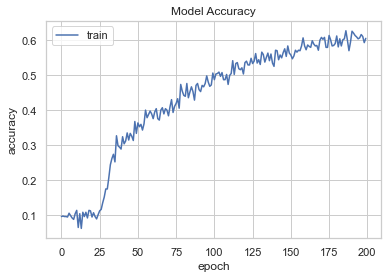

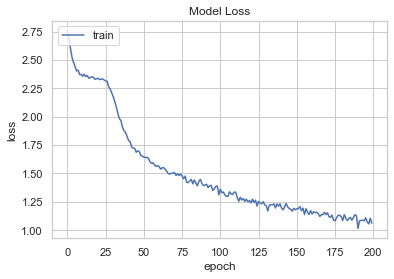

In [16]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [17]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            301056    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [18]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 50.543%


##### Confusion Matrix

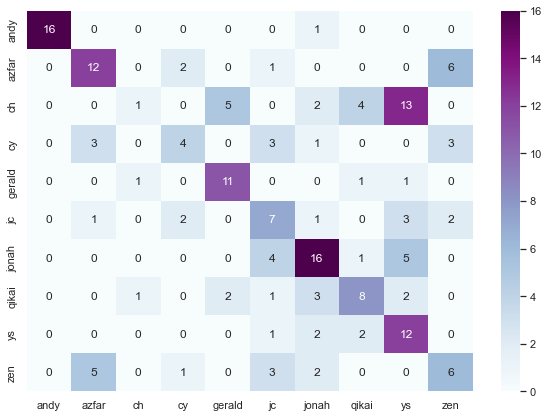

In [19]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

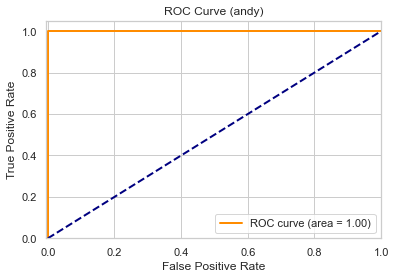

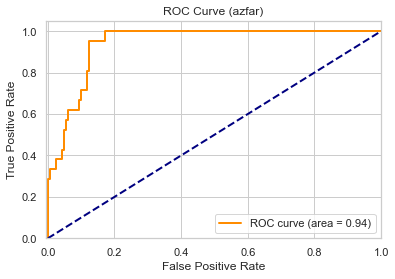

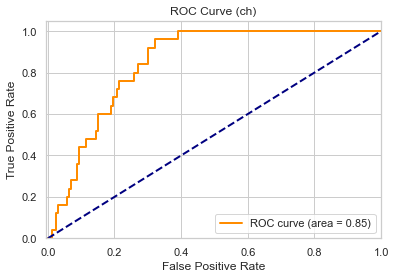

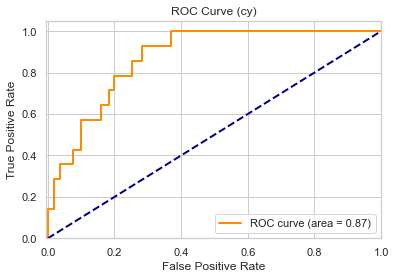

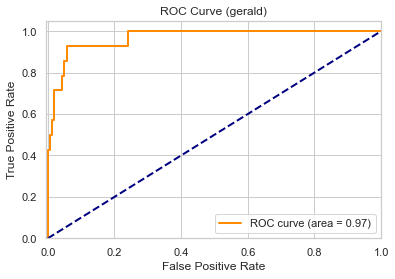

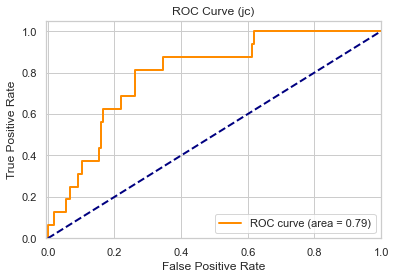

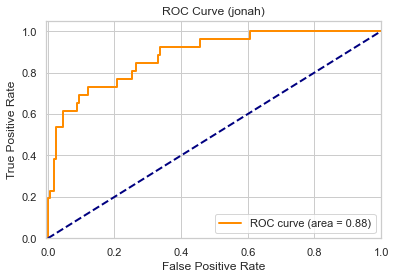

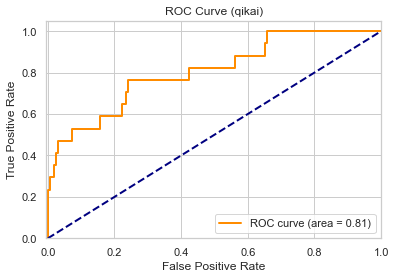

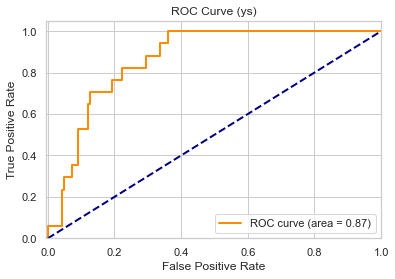

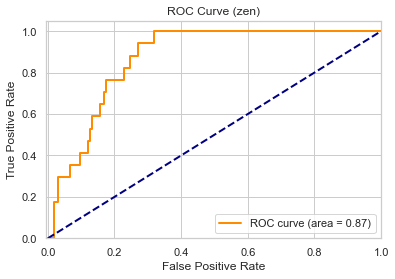

In [20]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

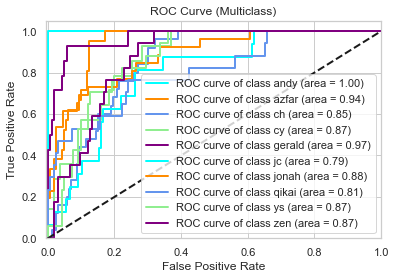

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

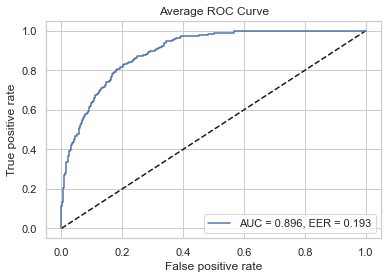

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving MOdel

In [ ]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'ch' 'cy' 'gerald' 'jc' 'jonah' 'qikai' 'ys' 'zen']


X | Features | Dataset Shape: (920, 37)
Y | Classes  | Dataset Shape: (920, 10)
10
Epoch 1/200


In [ ]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [ ]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [ ]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [ ]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

In [ ]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [ ]:
pred_dataset = pred_df.values
results = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = CLASS_LIST
print(Y)
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

In [ ]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))
pred_results = np.column_stack((results, pred_results))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
print(df)

df.to_csv(RESULT_PATH)